In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

## 1. Response distributions

Neurons do not respond in a deterministic manner to stimuli, which means that the firing rate in response to different trials with a particular stimulus will show some deviation around an average value. One way to take this variability into account is to describe neuronal responses by using probability distributions. A well-known distribution for continuous variables is the normal distribution, which is described by the following equation:

$$
f(x) = \dfrac{1}{\sqrt{2\pi\sigma^2}} e^{-\dfrac{(x-x_0)^2}{2\sigma^2}}
$$

We can either write our own function to describe this distribution, or we can use the scipy.stats package which allows us to generate values from the probability density function. Working with the scipy package brings the additional advantage that we automatically get access to many other functions, such as the cumulative distribution function, and tools that allow us to fit the normal distribution to data obtained from an experiment.

As an example, we show two distributions, which could represent the firing rate probability densities of a single neuron to two possible stimuli $S_+$ and $S_-$. As such, they are also known as the 'conditional response distributions'.

The prior stimulus are also included, and are necessary if we want to construct the total response distribution, which describes the probability density of responses over all stimuli that were presented.

In [2]:
# Distribution parameters
mu_1 = 5
sigma_1 = 1

mu_2 = 7
sigma_2 = 1

# Stimulus priors
prior = [0.5, 0.5]

# Generate the distributions
x = np.arange(3,10,0.01)
r_smin  = norm.pdf(x,mu_1,sigma_1)
r_splus = norm.pdf(x,mu_2,sigma_2)
r_total = prior[0]*r_smin + prior[1]*r_splus

The conditional response distributions and total response distribution are plotted.

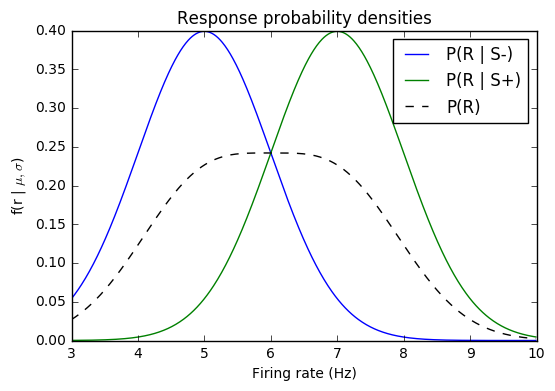

In [3]:
plt.plot(x,r_smin)
plt.plot(x,r_splus)
plt.plot(x,r_total,'--k')
plt.xlabel('Firing rate (Hz)')
plt.ylabel('f(r | $\mu, \sigma$)')
plt.legend(['P(R | S-)','P(R | S+)','P(R)'])
plt.title('Response probability densities')


## 2. Likelihood ratio

Suppose now that our neuron fires with rate $r$. Can we use the information given by the conditional response distributions to guess which stimulus was presented? It turns out that this is possible, and the answer is given by the likelihood ratio test.

This test says that we should choose $S_+$ every time that the probability for observing firing rate $r$ given that $S_+$ was shown is higher than the probability of observing $r$ when $S_-$ was shown. 

Continuous distributions such as the normal distribution describe probability densitities. An actual probability can be obtained by considering a small region $\Delta r$ around the observed rate $r$. In that case, our test corresponds to choosing $S_+$ whenever:

$$P(r | S_+)\Delta r > P(r | S_-)\Delta r$$

Rearranging the terms, we see that the $\Delta r$ cancel and we are left with:

$$\dfrac{P(r | S+)}{P(r | S-)} > 1$$

In this final form, the test is also known as the likelihood ratio. It is often useful to work with the logarithm of the likelihood ratio. For example, several important distributions involve exponential terms and using a logarithm allows to simplify these equations. 

In the following example we evaluate the log-likelihood ratio for all possible firing rates, which is done by taking the ratio of the conditional distributions. Because we take the logarithm of this result, the threshold value for saying that $S_+$ was presented is now zero, and is indicated with a vertical red line.


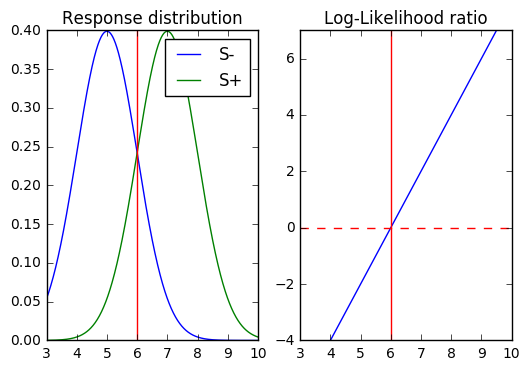

In [4]:
# Calculates the log-likelihood ratio
lr  = np.log(r_splus/r_smin)
lr_0 = np.argmax(lr >= 0)

plt.subplot(121)
plt.plot(x,r_smin)
plt.plot(x,r_splus)
plt.axvline(x[lr_0],linewidth=1,color='r')
plt.legend(['S-','S+'])
plt.title('Response distribution')
plt.subplot(122)
plt.plot(x,lr)
plt.axhline(y=0,linewidth = 1,linestyle='--', color='r')
plt.axvline(x[lr_0],linewidth=1,color='r')
plt.ylim(-4,7)
plt.title('Log-Likelihood ratio')

## 3. Sampling the response distribution

It has been found that neurons in the brain related to decision making integrate their activity over time until a threshold value is reached. This accumulation process can be simulated with the current framework by assuming that the response distribution is sampled repeatedly. 

As an example, assume that the $S_+$ stimulus is shown for 500 ms. Although this presentation will generate a total spike count over the stimulus presentation interval, we can also think that the presentation of the stimulus generates response distributions at finer time scales (say 50 ms). In each block of 50 ms we thus have a sample of the response distribution for which we can calculate the likelihood ratio.

This process is illustrated in the following code, in which we 

1. Generate response samples for the $S_+$ and the $S_-$ stimulus
2. For each sample we calculate the likelihood ratio
3. Accumulate these values over time.

A decision can be made by setting a threshold value that needs to be crossed.

[[  0.           0.73415553  -1.39654698  -0.99777044  -3.55591349
   -1.46755488  -3.47511823  -7.1586933  -12.57212769          nan]
 [  0.           4.02592353   6.14428336   8.74421151  13.40730336
           nan          nan          nan          nan          nan]]


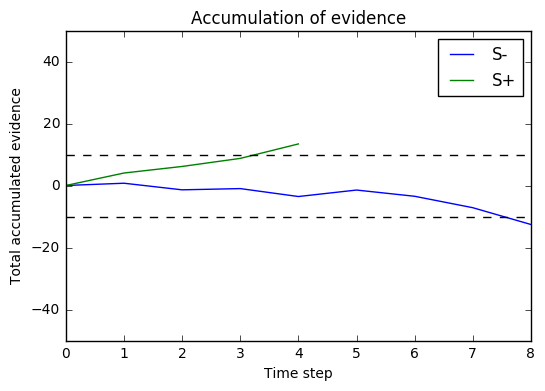

In [20]:
n_samples = 10
evidence = np.full((2,n_samples),np.nan)
evidence[:,0] = 0
threshold = 10

# Case 1: S- is presented
for i in range(1,n_samples):
    # Sample
    r  = np.random.normal(mu_1,sigma_1)
    lr_sample = norm.pdf(r,mu_2,sigma_2)/norm.pdf(r,mu_1,sigma_1)
    
    # Accumulate
    evidence[0,i] = evidence[0,i-1] + np.log(lr_sample)
    
    # Check threshold
    if evidence[0,i] < -threshold:
        break

# Case 2: S+ is presented
for i in range(1,n_samples):
    r  = np.random.normal(mu_2,sigma_2)
    lr_sample = norm.pdf(r,mu_2,sigma_2)/norm.pdf(r,mu_1,sigma_1)
    evidence[1,i] = evidence[1,i-1] +  np.log(lr_sample)
    if evidence[1,i] > threshold:
        break

print(evidence)
plt.plot(evidence.transpose())
plt.ylim(-50,50)
plt.title('Accumulation of evidence')
plt.xlabel('Time step')
plt.ylabel('Total accumulated evidence')
plt.legend(['S-','S+'])
plt.axhline(threshold,color='k',linestyle='--')
plt.axhline(-threshold,color='k',linestyle='--')

## 4. Taking priors into account

Until now we have assumed that both S+ and S- were presented with equal probabilities. The interesting thing about the likelihood calculation framework is that it can be extended in a straightforward way to take prior stimulus probabilities into account. If the prior stimulus probabilities are not equal, the critical value that should be compared to is:

$$
\dfrac{P(R | S_+)}{P(R | S_-)} > \dfrac{P(S_-)}{P(S_+)}
$$


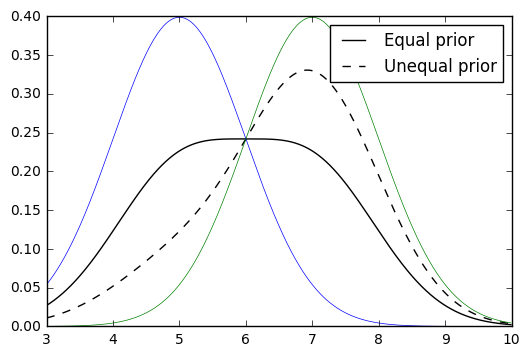

In [21]:
prior = [0.2, 0.8]

r_smin = norm.pdf(x,mu_1,sigma_1)
r_splus = norm.pdf(x,mu_2,sigma_2)
r_prior = prior[0]*r_smin + prior[1]*r_splus

plt.plot(x, r_total,'-k')
plt.plot(x, r_prior,'--k')
plt.plot(x, r_smin,linewidth=0.5)
plt.plot(x, r_splus,linewidth=0.5)
plt.legend(['Equal prior','Unequal prior'])

The effect of unbalanced stimulus distributions can be seen in the shape of the total response distribution (the conditional response probabilities remain the same). For balanced stimulus presentations, we get a symmetrical distribution. If the $S_+$ stimulus is presented more often, we expect more responses in the range corresponding to that stimulus. This is reflected in the increase of the rightmost peak of the total response distribution.

The intuitive idea for adjusting the comparison value for the likelihood ratio test is that if on a given trial it is more likely that an $S_+$ will be presented, we can safely lower our response threshold somewhat because most responses will be generated by that stimulus anyway. In the following plot we show the new criterion value for equal and unequal priors.


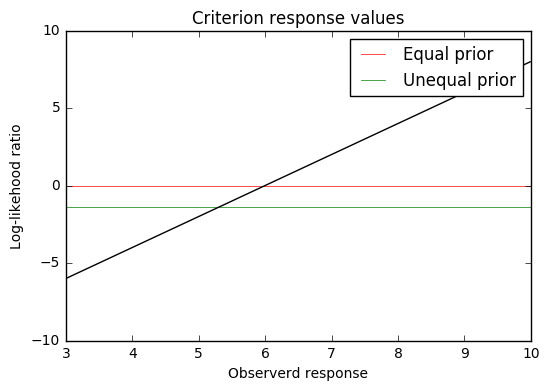

In [22]:
plt.axhline(y=0,linewidth = 0.5,linestyle='-', color='r')
plt.axhline(y=np.log(prior[0]/prior[1]),linewidth=0.5,linestyle='-',color = 'g')
plt.plot(x, lr,'-k')
plt.ylim(-10,10)
plt.legend(['Equal prior','Unequal prior'])
plt.xlabel('Observerd response')
plt.ylabel('Log-likehood ratio')
plt.title('Criterion response values')

Finally, it can be useful to adjust the criterion value for making wrong decisions. For example, when the $S$ signals the presence or absence of a dangerous object in the environment that should be avoided, mistakenly deciding that the object was not there while in fact it was could have worse consequences that mistakenly deciding that the object was there when it was not. To take this into account, we can include a penalty term for incorrectly detecting the $S_+$ stimulus ($L_+$) and for incorrectly the $S_-$ stimulus ($L_-$):


$$
\dfrac{P(R | S+)}{P(R | S-)} > \dfrac{L_+ P(-)}{L_- P(+)}
$$

The equation with which we started is the special case where both the penalties and prior probabilities are equal.

## 5. Neurons and anti-neurons

One subtlety in the previous discussion is that it is unlikely that real neurons have access to the complete conditional probability distributions. In other words, while it is a convenient tool for us to decode stimulus information after we have conducted numerous experiments to characterize the response distributions, real neurons simply not calculating likelihood ratios.

One way out of this is to assume that the conditional response distributions are generated by different neurons, so that in stead of calculating a likelihood ratio, decision neurons can look at the difference between neural activity rates.

A simulation indicates that this approach also has a good performance. To show this, we use the following approach:
1. Generate responses from the $S_+$ distribution and the $S_-$ distribution. These responses reflect the activity of a neuron/anti-neuron pair.

2. Substract the $S_+$ rate from the $S_-$ rate. If the difference is positive, we decide that the $S_+$ stimulus was shown.

3. Alternatively, we calculate the likelihood ratio for each $S_+$ and each $S_-$

In [24]:
n_stimuli = 100

antineuron_response = np.random.normal(mu_1,sigma_1,100)
neuron_response     = np.random.normal(mu_2,sigma_2,100)

# Compare neuron and anti_neuron response
response_difference = neuron_response - antineuron_response
correct_2 = (np.sum(lr_test_1 > 1) + np.sum(lr_test_2 > 1))/2

# Calculate the results from the likelihood ratio test for the same values
lr_test_1 = norm.pdf(neuron_response, mu_2,sigma_2)/norm.pdf(neuron_response,mu_1,sigma_1)
lr_test_2 = norm.pdf(antineuron_response, mu_1,sigma_1)/norm.pdf(antineuron_response,mu_2,sigma_2)
correct_1 = np.sum(response_difference>0)

print ('Correct responses: ' + str(correct_1))
print ('Correct responses: ' + str(correct_2))

Correct responses: 93
Correct responses: 83
